# Anchor-Anchor Output Distance
**Goal**: Analyze the distance between the output representation within each set of anchors

In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import cosine_distances, manhattan_distances
sns.set_style('darkgrid')

# Load Data

In [2]:
LAYER = 'output'

In [3]:
# Load anchor-probes mapping
anchor_probe_mapping = pd.read_pickle(f'../../dataset/anchor_probe_mapping_20210729.pkl')
anchor_probe_mapping = anchor_probe_mapping.rename(columns={'probes': 'probe'})
anchor_probe_mapping.head()

,anchors,probe,type
0,"[bive, kive, tive]","[zive, mive, pive, rive]",AMB
1,"[blome, prome, thome]","[shome, flome, grome, chome]",AMB
2,"[clead, smead, pread]","[snead, glead, thead, kread]",AMB
3,"[frow, clow, spow]","[zow, trow, fow, smow]",AMB
4,"[grour, snour, frour]","[brour, drour, prour, trour]",AMB


In [4]:
all_anchors_data = []
anchor_list = sum(anchor_probe_mapping['anchors'].tolist(), [])

# NOTE: We exclude dilution 1 b/c we don't need to compare distance of anchors with itself
for dilution in tqdm(range(2, 4)): 
    for partition in range(3):
        # ANCHORS
        
        anchor_types = [f"ANC_{i}" for i in ['REG', 'EXC', 'AMB']]

        anchor_data = pd.read_pickle(f'cogsci-recurrent-dt-100-dilution-{dilution}-seed-1-partition-{partition}-straight-through/results/activations-anchors-{LAYER}.pkl')

        anchor_data = anchor_data[anchor_data['word_type'].isin(anchor_types)]
        anchor_data = anchor_data[anchor_data['orth'].isin(anchor_list)]
        anchor_data = anchor_data.drop_duplicates(subset=['epoch', 'orth'])
        anchor_data['dilution'] = dilution
        anchor_data['partition'] = partition
        all_anchors_data.append(anchor_data)

all_anchors_data = pd.concat(all_anchors_data).reset_index(drop=True)

100%|██████████| 2/2 [00:01<00:00,  1.75it/s]


In [5]:
all_anchors_data.head()

,epoch,output,word_id,orth,phon,word_type,target,dilution,partition
0,0,"[0.9697242, 0.8768854, 0.5241958, 0.9961588, 0...",43,trest,trEst,ANC_EXC,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,0
1,0,"[0.9956714, 0.967945, 0.4956824, 0.9963598, 0....",47,fipe,fip,ANC_EXC,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",2,0
2,0,"[0.9687282, 0.806269, 0.6032637, 0.9977242, 0....",5,plone,plan,ANC_AMB,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,0
3,0,"[0.9866151, 0.7744268, 0.4363262, 0.9992097, 0...",25,plig,plig,ANC_REG,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,0
4,0,"[0.9942476, 0.8880208, 0.5812567, 0.9962376, 0...",2,clead,kled,ANC_AMB,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,0


## Calculation of Distance

We use two distance metrics - cosine distance, and L1 distance. The documentation for these two distance metrics are available here:
* [Cosine Distance](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_distances.html#sklearn.metrics.pairwise.cosine_distances)
* [Manhattan Distance](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.manhattan_distances.html#sklearn.metrics.pairwise.manhattan_distances)

In [6]:
results = []

for dilution in all_anchors_data['dilution'].unique():
    for partition in all_anchors_data['partition'].unique():
        
        trial_data = all_anchors_data[(all_anchors_data['dilution'] == dilution) & 
                                      (all_anchors_data['partition'] == partition)]

        for i, row in tqdm(anchor_probe_mapping.iterrows(), 
                           total=len(anchor_probe_mapping), 
                           desc=f"Dilution {dilution} - Partition {partition}"):
            anchor_data = trial_data[trial_data['orth'].isin(row['anchors'])]

            for epoch in anchor_data['epoch'].unique():
                epoch_anchor_data = np.array(anchor_data[anchor_data['epoch'] == epoch][LAYER].tolist())

                results.append({
                    'dilution': dilution,
                    'partition': partition,
                    'epoch': epoch,
                    f'anchors': row['anchors'],
                    'type': row['type'],
                    'cosine_distances': cosine_distances(epoch_anchor_data, epoch_anchor_data),
                    'l1_distances': manhattan_distances(epoch_anchor_data, epoch_anchor_data)
                })

Dilution 3 - Partition 2: 100%|██████████| 30/30 [00:06<00:00,  4.36it/s]


In [7]:
results_df = pd.DataFrame(results)
# remove distance with itself
results_df['cosine_distances'] = results_df['cosine_distances'].apply(lambda x: x[~np.eye(x.shape[0],dtype=bool)].reshape(x.shape[0],-1))
results_df['l1_distances'] = results_df['l1_distances'].apply(lambda x: x[~np.eye(x.shape[0],dtype=bool)].reshape(x.shape[0],-1))
# calculate mean distance
results_df['mean_cosine_distance'] = results_df['cosine_distances'].apply(lambda x: x.mean() if x.size > 0 else 0)
results_df['mean_l1_distance'] = results_df['l1_distances'].apply(lambda x: x.mean() if x.size > 0 else 0)
results_df[f'first_anchor'] = results_df[f'anchors'].apply(lambda x: x[0])
results_df = results_df.sort_values(by=['epoch', 'type', f'first_anchor']).reset_index(drop=True)

In [8]:
results_df.head()

,dilution,partition,epoch,anchors,type,cosine_distances,l1_distances,mean_cosine_distance,mean_l1_distance,first_anchor
0,2,0,0,"[bive, kive, tive]",AMB,"[[0.004193409583315488], [0.004193409583315488]]","[[2.4506181225070005], [2.4506181225070005]]",0.004193,2.450618,bive
1,2,1,0,"[bive, kive, tive]",AMB,"[[0.002947659051698248], [0.002947659051698248]]","[[1.9620870046339993], [1.9620870046339993]]",0.002948,1.962087,bive
2,2,2,0,"[bive, kive, tive]",AMB,"[[0.004193409583315488], [0.004193409583315488]]","[[2.4506181225070005], [2.4506181225070005]]",0.004193,2.450618,bive
3,3,0,0,"[bive, kive, tive]",AMB,"[[0.004193409583315488, 0.002947659051698137],...","[[2.4506181225070005, 1.9620870046339993], [2....",0.003249,2.139101,bive
4,3,1,0,"[bive, kive, tive]",AMB,"[[0.002947659051698248, 0.004193409583315599],...","[[1.9620870046339993, 2.4506181225070005], [1....",0.003249,2.139101,bive


In [9]:
results_df = results_df[(results_df['epoch'] >= 100)]

## Mean Cosine and L1 Distance by Type

In [10]:
TYPE = 'Anchor'

### Overall Results
This first pair of graphs aggregate across dilution and partitions. Each dilution-partition combo is treated as one datapoint. 

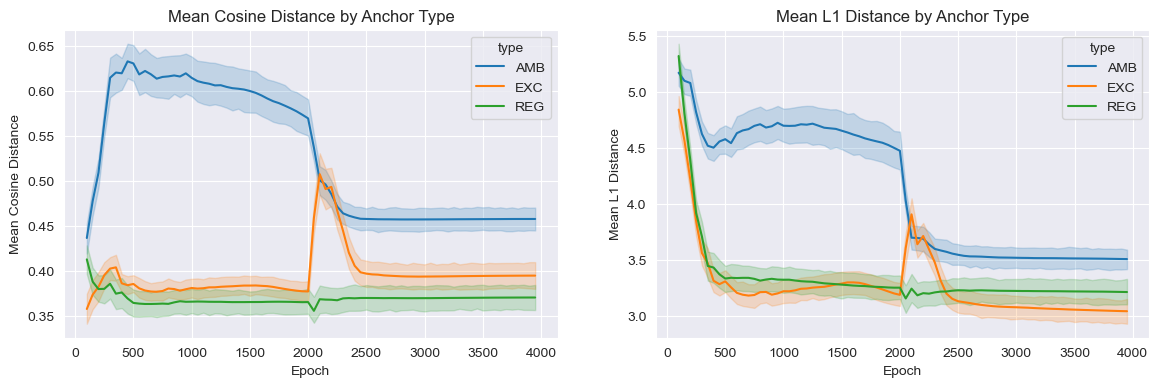

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

sns.lineplot(data=results_df, x='epoch', y='mean_cosine_distance', hue='type', ax=ax1, ci=68)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Mean Cosine Distance')
ax1.set_title(f'Mean Cosine Distance by {TYPE.title()} Type')

sns.lineplot(data=results_df, x='epoch', y='mean_l1_distance', hue='type', ax=ax2, ci=68)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean L1 Distance')
ax2.set_title(f'Mean L1 Distance by {TYPE.title()} Type')

plt.show()

### Distance by Dilution Level (split by word type)
In the next 3 sets of graphs, we look at each regularity type individually, but combine all three dilution levels in the same plot. The three partitions are grouped together.

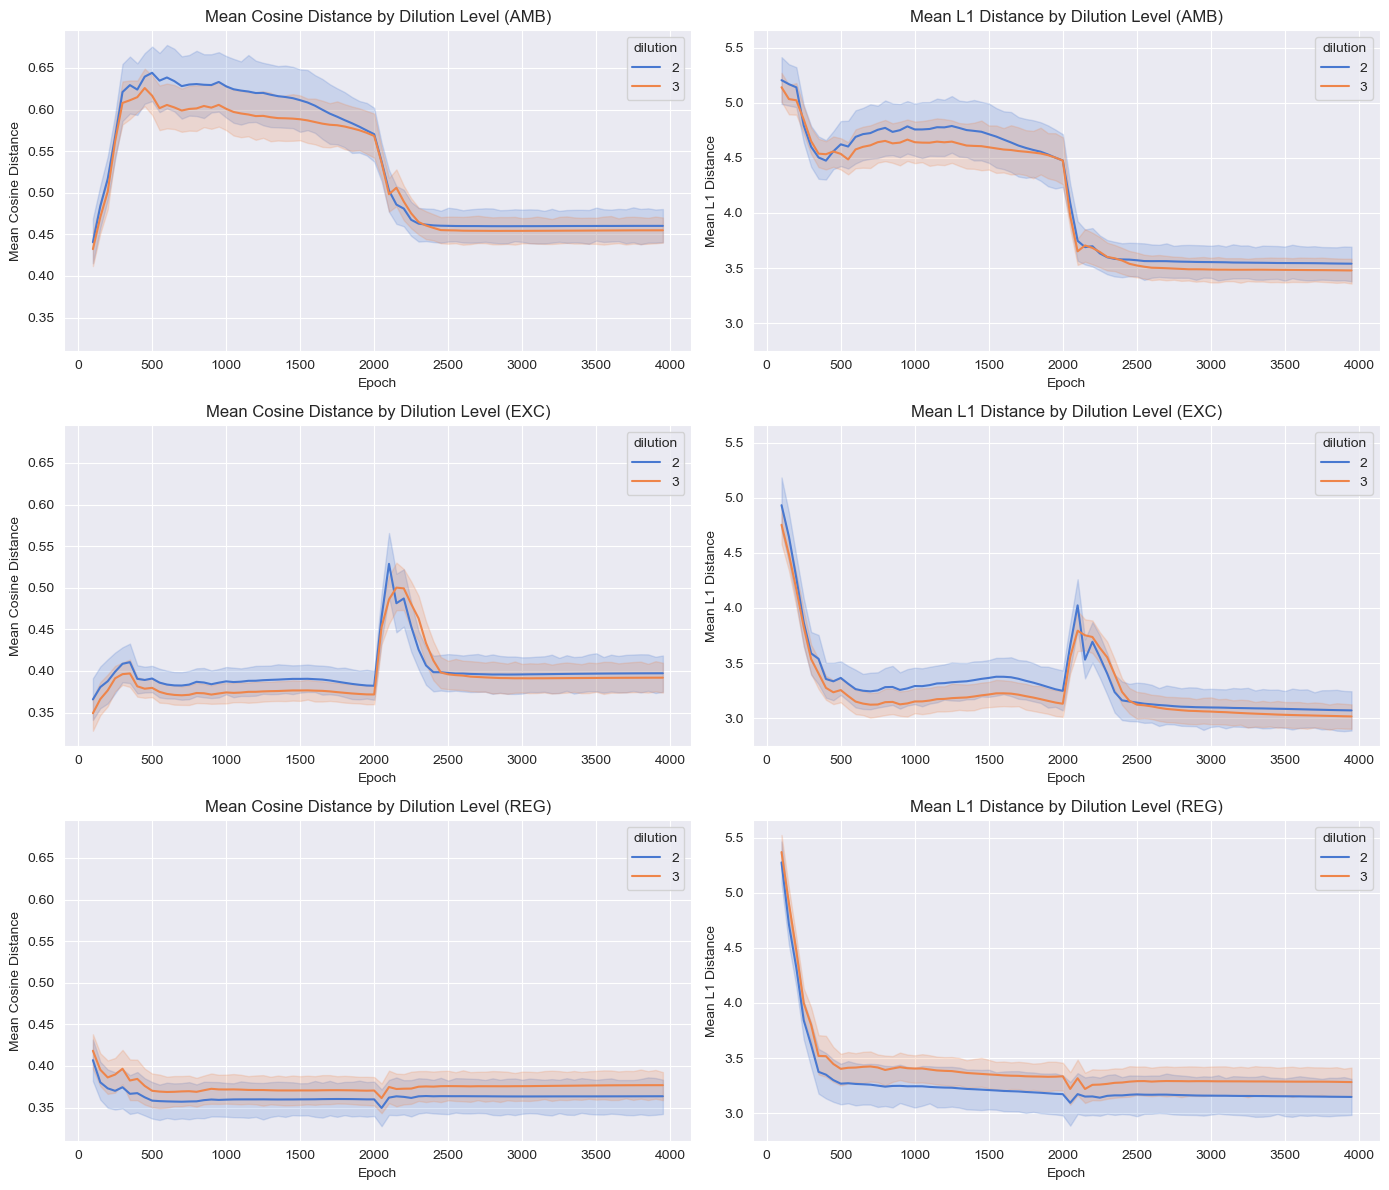

In [12]:
fig, axs = plt.subplots(3, 2, figsize=(14, 12), sharey='col')

for word_type, ax in zip(results_df['type'].unique(), axs):
    sns.lineplot(data=results_df[results_df['type'] == word_type], x='epoch', y='mean_cosine_distance', hue='dilution',
                 ax=ax[0], ci=68, palette='muted')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Mean Cosine Distance')
    ax[0].set_title(f'Mean Cosine Distance by Dilution Level ({word_type})')

    sns.lineplot(data=results_df[results_df['type'] == word_type], x='epoch', y='mean_l1_distance', hue='dilution',
                 ax=ax[1], ci=68, palette='muted')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Mean L1 Distance')
    ax[1].set_title(f'Mean L1 Distance by Dilution Level ({word_type})')

plt.tight_layout()
plt.show()

### Distance by Regularity Type (split by Dilution Level)
In the next 3 sets of graphs, we look at each dilution level individually, but combine all three regularity types in the same plot. The three partitions are grouped together.

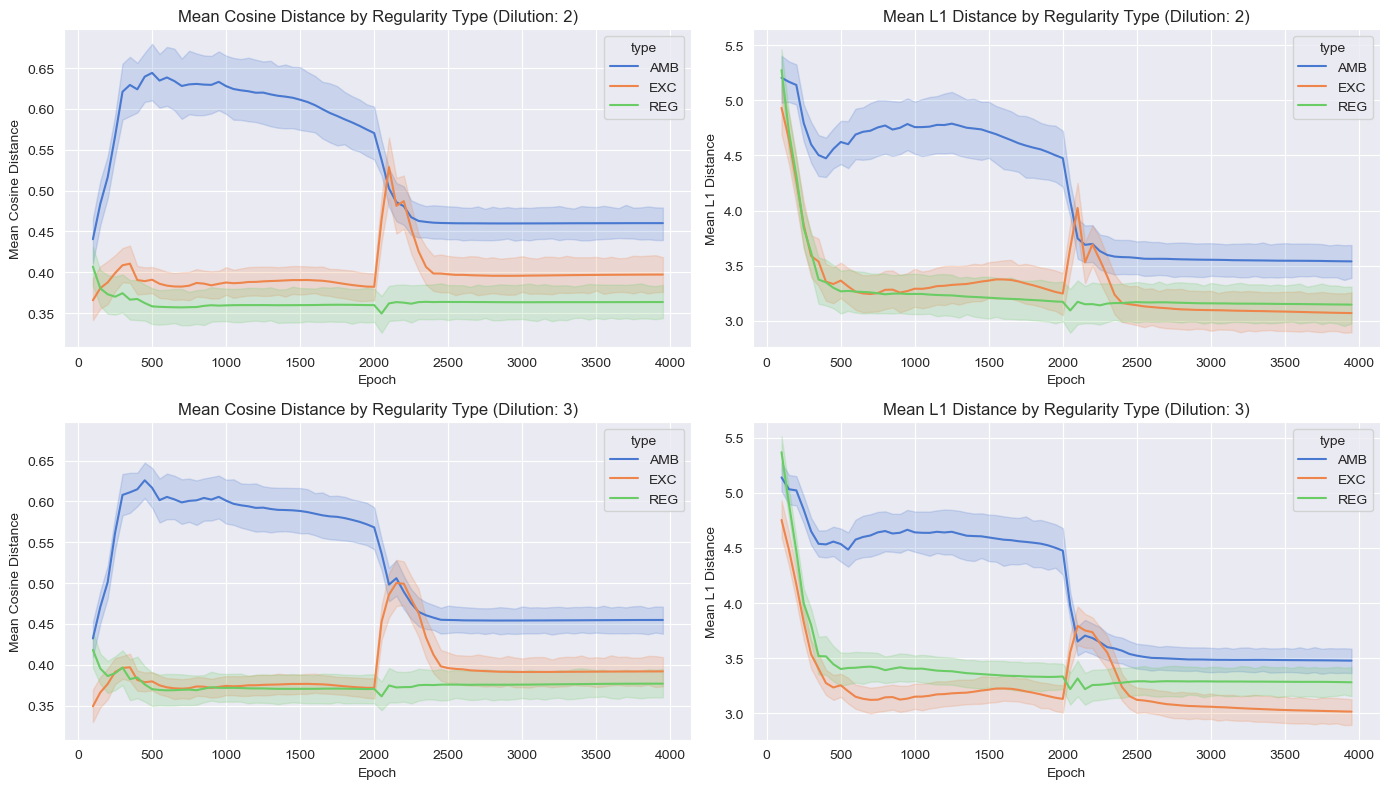

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(14, 8), sharey='col')

for dilution, ax in zip(results_df['dilution'].unique(), axs):
    sns.lineplot(data=results_df[results_df['dilution'] == dilution], x='epoch', y='mean_cosine_distance', hue='type',
                 ax=ax[0], ci=68, palette='muted')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Mean Cosine Distance')
    ax[0].set_title(f'Mean Cosine Distance by Regularity Type (Dilution: {dilution})')

    sns.lineplot(data=results_df[results_df['dilution'] == dilution], x='epoch', y='mean_l1_distance', hue='type',
                 ax=ax[1], ci=68, palette='muted')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Mean L1 Distance')
    ax[1].set_title(f'Mean L1 Distance by Regularity Type (Dilution: {dilution})')

plt.tight_layout()
plt.show()

### Dilution Level 2 by Word Type
In the next 3 sets of graphs, we look at each **partition** level individually for dilution level 2, but combine all three regularity types in the same plot. The three partitions are grouped together.

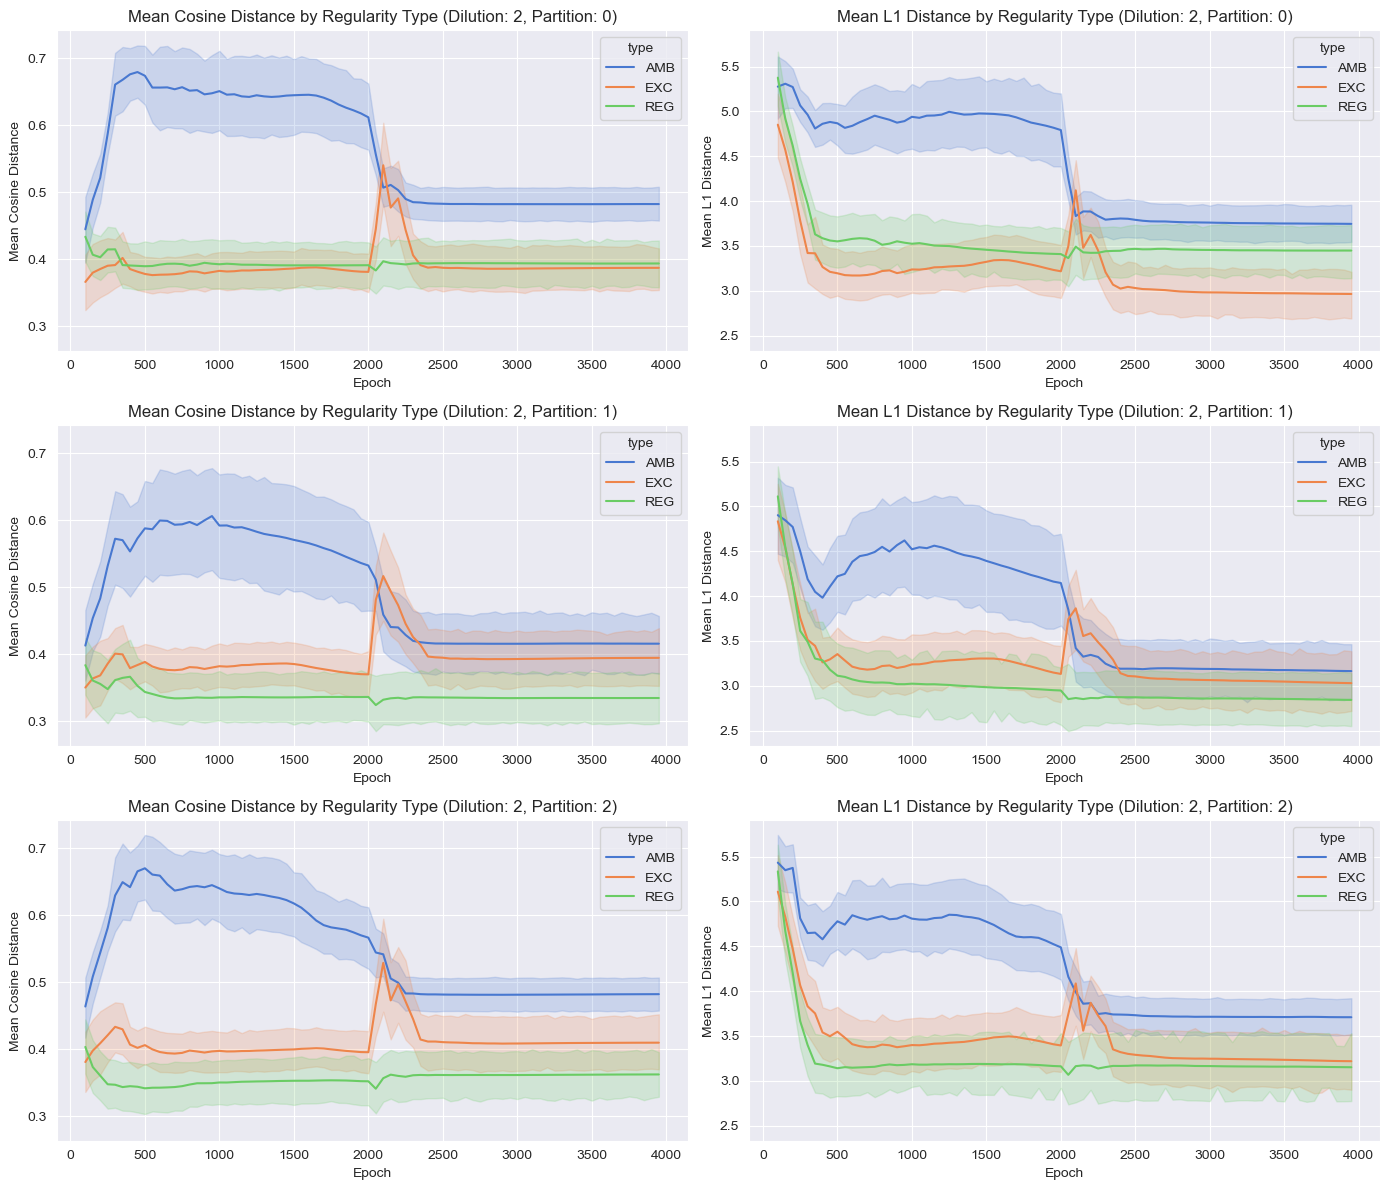

In [14]:
fig, axs = plt.subplots(3, 2, figsize=(14, 12), sharey='col')
dilution = 2
temp_results = results_df[results_df['dilution'] == dilution]

for partition, ax in zip(sorted(temp_results['partition'].unique()), axs):
    sns.lineplot(data=temp_results[temp_results['partition'] == partition], x='epoch', y='mean_cosine_distance', hue='type',
                 ax=ax[0], ci=68, palette='muted')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Mean Cosine Distance')
    ax[0].set_title(f'Mean Cosine Distance by Regularity Type (Dilution: {dilution}, Partition: {partition})')

    sns.lineplot(data=temp_results[temp_results['partition'] == partition], x='epoch', y='mean_l1_distance', hue='type',
                 ax=ax[1], ci=68, palette='muted')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Mean L1 Distance')
    ax[1].set_title(f'Mean L1 Distance by Regularity Type (Dilution: {dilution}, Partition: {partition})')

plt.tight_layout()
plt.show()

### Dilution Level 3 by Word Type
In the next 3 sets of graphs, we look at each **partition** level individually for dilution level 3, but combine all three regularity types in the same plot. The three partitions are grouped together.

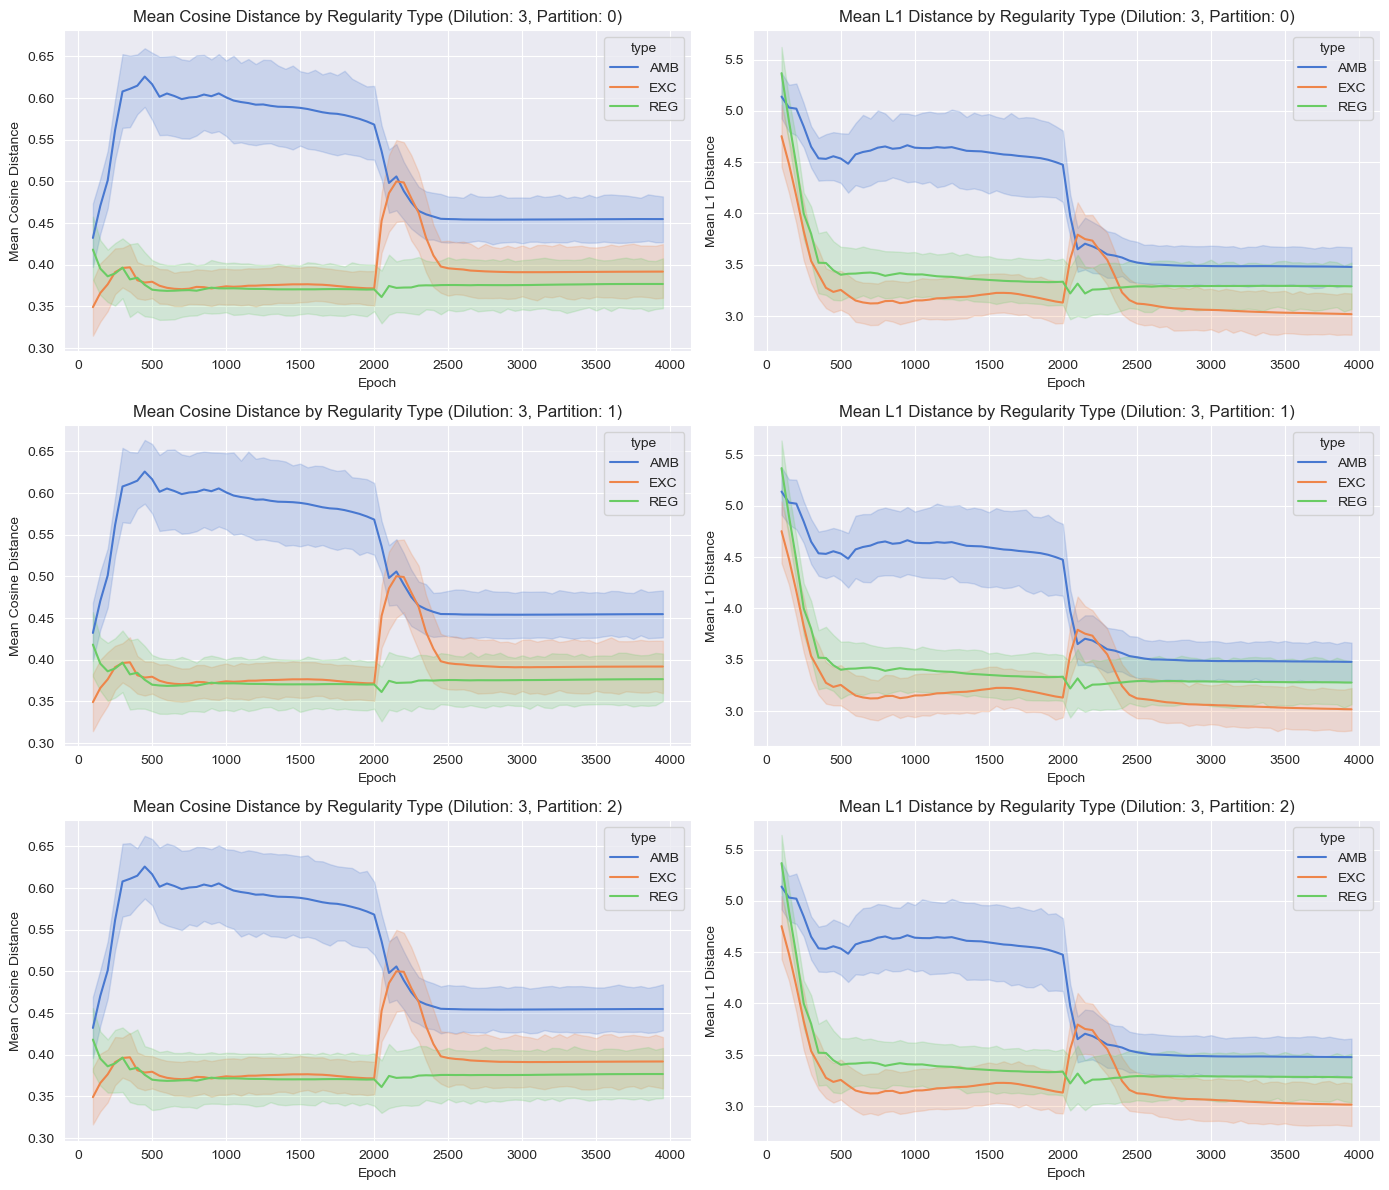

In [15]:
fig, axs = plt.subplots(3, 2, figsize=(14, 12), sharey='col')
dilution = 3
temp_results = results_df[results_df['dilution'] == dilution]

for partition, ax in zip(sorted(temp_results['partition'].unique()), axs):
    sns.lineplot(data=temp_results[temp_results['partition'] == partition], x='epoch', y='mean_cosine_distance', hue='type',
                 ax=ax[0], ci=68, palette='muted')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Mean Cosine Distance')
    ax[0].set_title(f'Mean Cosine Distance by Regularity Type (Dilution: {dilution}, Partition: {partition})')

    sns.lineplot(data=temp_results[temp_results['partition'] == partition], x='epoch', y='mean_l1_distance', hue='type',
                 ax=ax[1], ci=68, palette='muted')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Mean L1 Distance')
    ax[1].set_title(f'Mean L1 Distance by Regularity Type (Dilution: {dilution}, Partition: {partition})')

plt.tight_layout()
plt.show()

## Distance by Word Set
* We refer to each anchor/probe set by the first anchor/probe.

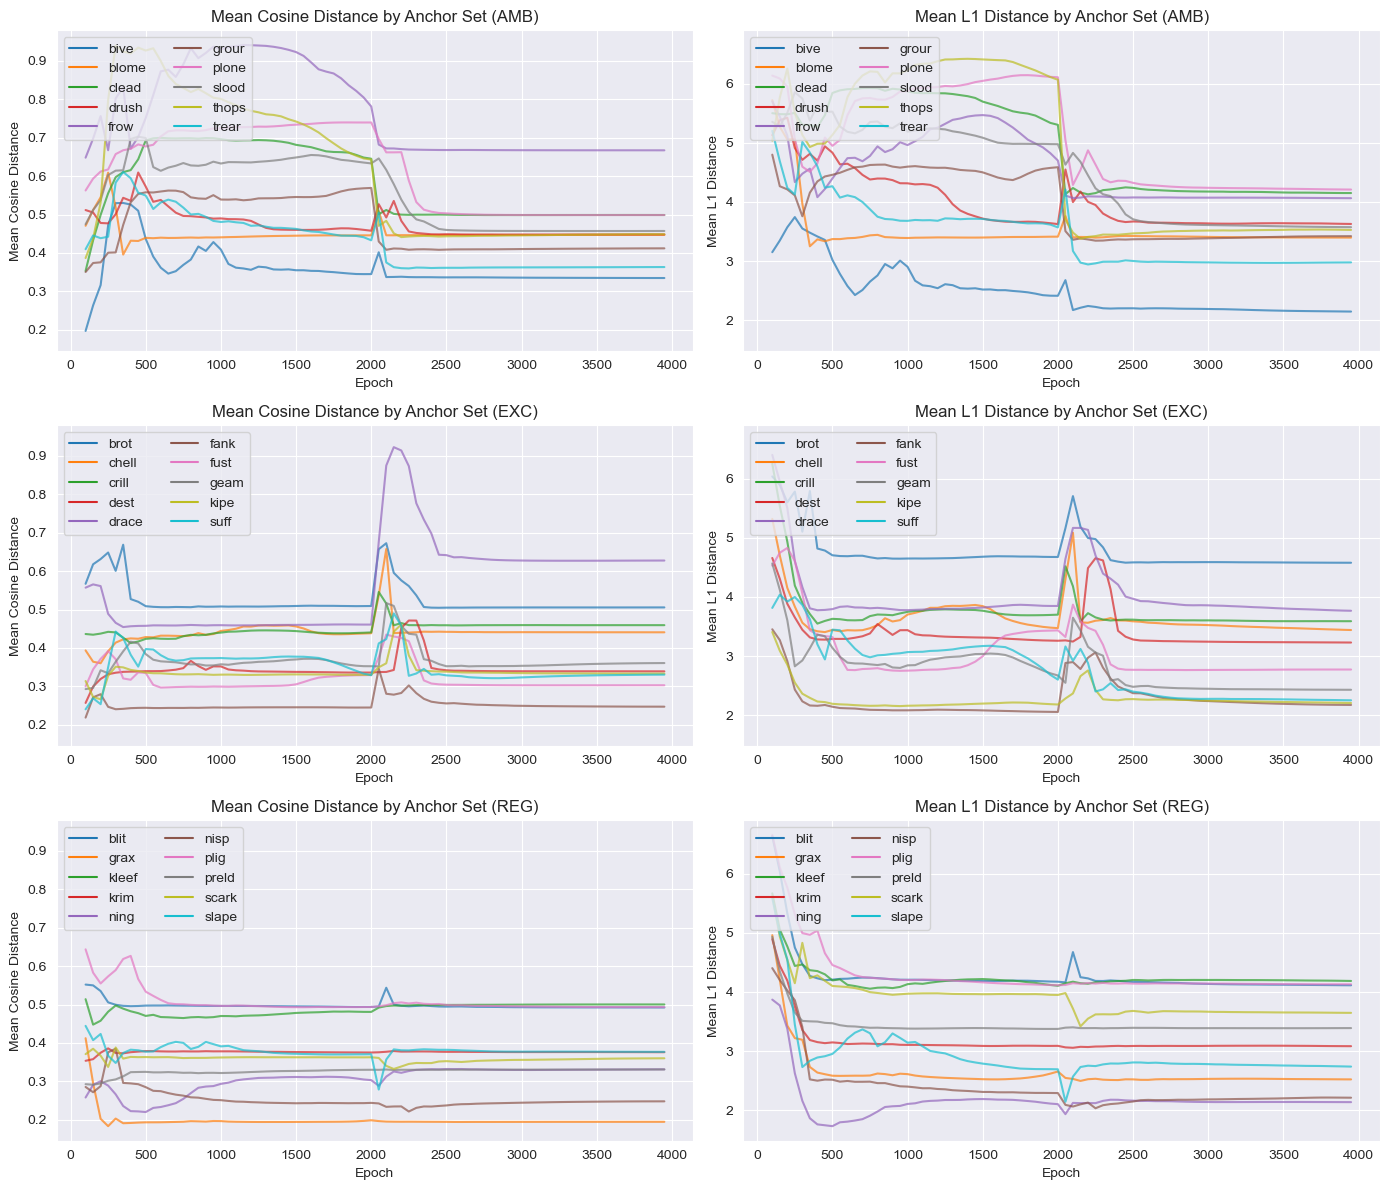

In [16]:
fig, axs = plt.subplots(3, 2, figsize=(14, 12), sharey='col')

for word_type, ax in zip(results_df['type'].unique(), axs):
    sns.lineplot(data=results_df[results_df['type'] == word_type], x='epoch', y='mean_cosine_distance', hue='first_anchor',
                 alpha=0.7, ax=ax[0], ci=None)
    ax[0].legend(ncol=2, loc='upper left')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Mean Cosine Distance')
    ax[0].set_title(f'Mean Cosine Distance by {TYPE.title()} Set ({word_type})')

    sns.lineplot(data=results_df[results_df['type'] == word_type], x='epoch', y='mean_l1_distance', hue='first_anchor',
                 alpha=0.7, ax=ax[1], ci=None)
    ax[1].legend(ncol=2, loc='upper left')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Mean L1 Distance')
    ax[1].set_title(f'Mean L1 Distance by {TYPE.title()} Set ({word_type})')

plt.tight_layout()
plt.show()